In [58]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
%matplotlib inline

In [2]:
train_raw = pickle.load(open('./feat_descrip.pickle','r'))
test_raw = pickle.load(open('./feat_descrip_TEST.pickle','r'))
label = pickle.load(open('./label_variety.pickle','r'))
label_ts = pickle.load(open('./label_variety_TEST.pickle','r'))

In [12]:
train_feat = train_raw.toarray()
train_label = to_categorical(label, n_class)
val_feat = test_raw.toarray()
val_label = to_categorical(label_ts, n_class)

In [4]:
vocab_size = train_raw.shape[1]
n_class = max(label) + 1

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from keras.callbacks import Callback, EarlyStopping
from keras.utils.np_utils import to_categorical

In [68]:
model = Sequential()
model.add(Dense(512, input_dim=vocab_size))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.75))
model.add(Dense(n_class, activation='softmax'))

def top_3_categorical_accuracy(x, y, k=3):
    return top_k_categorical_accuracy(x, y, k=3)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_3_categorical_accuracy, top_k_categorical_accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 512)               10265600  
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 560)               287280    
Total params: 10,554,928
Trainable params: 10,553,904
Non-trainable params: 1,024
_________________________________________________________________


In [69]:
class History(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.top1_acc, self.top3_acc, self.top5_acc = [], [], []
        self.val_losses = []
        self.val_top1_acc, self.val_top3_acc, self.val_top5_acc = [], [], []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.top1_acc.append(logs.get('categorical_accuracy'))
        self.top3_acc.append(logs.get('top_3_categorical_accuracy'))
        self.top5_acc.append(logs.get('top_k_categorical_accuracy'))

    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_top1_acc.append(logs.get('val_categorical_accuracy'))
        self.val_top3_acc.append(logs.get('val_top_3_categorical_accuracy'))
        self.val_top5_acc.append(logs.get('val_top_k_categorical_accuracy'))

history = History()
earlystop = EarlyStopping()

In [70]:
model.fit(train_feat, train_label, 
          batch_size=128, 
          epochs=5, 
          shuffle=True, 
          callbacks=[history, earlystop],
          validation_data=(val_feat, val_label))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 13s 254us/step - loss: 2.9388 - categorical_accuracy: 0.3997 - top_3_categorical_accuracy: 0.5848 - top_k_categorical_accuracy: 0.6608 - val_loss: 3.7751 - val_categorical_accuracy: 0.5443 - val_top_3_categorical_accuracy: 0.7345 - val_top_k_categorical_accuracy: 0.8012
Epoch 2/5
50000/50000 [==============================] - 11s 224us/step - loss: 1.8344 - categorical_accuracy: 0.5896 - top_3_categorical_accuracy: 0.7633 - top_k_categorical_accuracy: 0.8253 - val_loss: 1.8200 - val_categorical_accuracy: 0.5807 - val_top_3_categorical_accuracy: 0.7615 - val_top_k_categorical_accuracy: 0.8269
Epoch 3/5
50000/50000 [==============================] - 11s 223us/step - loss: 1.3990 - categorical_accuracy: 0.6758 - top_3_categorical_accuracy: 0.8337 - top_k_categorical_accuracy: 0.8800 - val_loss: 1.7830 - val_categorical_accuracy: 0.5897 - val_top_3_categorical_accuracy: 0.7679 - val_t

In [71]:
model.evaluate(val_feat, val_label)

10000/10000 [==============================] - 2s 247us/step


[1.8178871997833252,
 0.59040000000000004,
 0.76749999999999996,
 0.83579999999999999]

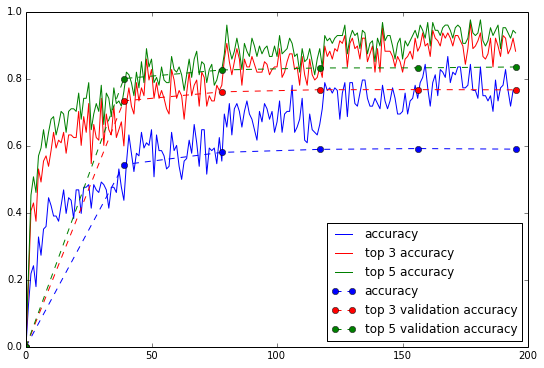

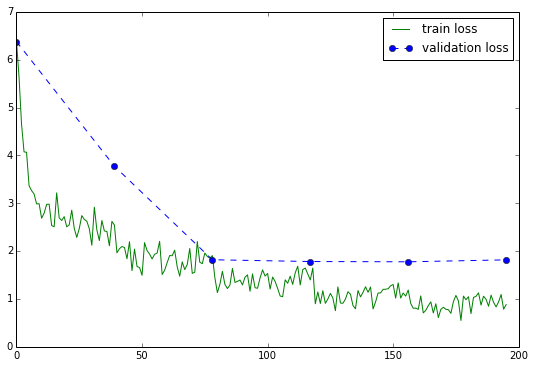

In [106]:
plt.figure(figsize=(9, 6))
n_batch, n_epoch = len(history.top1_acc), len(history.val_top1_acc)
plt.plot(history.top1_acc[::10], 'b', label='accuracy')
plt.plot(history.top3_acc[::10], 'r', label='top 3 accuracy')
plt.plot(history.top5_acc[::10], 'g', label='top 5 accuracy')
plt.plot(np.linspace(0, n_batch / 10, n_epoch + 1), [0] + history.val_top1_acc, 'b--o', label='accuracy')
plt.plot(np.linspace(0, n_batch / 10, n_epoch + 1), [0] + history.val_top3_acc, 'r--o', label='top 3 validation accuracy')
plt.plot(np.linspace(0, n_batch / 10, n_epoch + 1), [0] + history.val_top5_acc, 'g--o', label='top 5 validation accuracy')
plt.legend(loc=4)

plt.figure(figsize=(9, 6))
plt.plot(history.losses[::10], 'g', label='train loss')
plt.plot(np.linspace(0, n_batch / 10, n_epoch + 1), [history.losses[0]] + history.val_losses, 'b--o', label='validation loss')
plt.legend()